This notebook is aimed at using plotly to find diurnal variations in data.

In [92]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import time
import plotly.express as pe
import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.colors as colors
import matplotlib.pyplot as plt

from datetime import datetime

#
os.chdir('/Users/gaurav/UAH/temperature_modelling/')

from lib import dataprocess as dp
from lib import crowdqc as cqc

In [ ]:
dp.plot_(grouped_data_normal[grouped_data_normal.station=='KWIMADIS162'], animation_frame_comp='hour',resample=False)


Analysis of Fault stations

In [ ]:
data = pd.read_csv('/Users/gaurav/UAH/temperature_modelling/data/processed_data/Madison_2021/master_Madison_pws_.csv')

In [ ]:
missing_stations = []
for x in non_flags:
    fitch_38 = data[data.stationID==x]
    fitch_38 = fitch_38[(fitch_38.obsTimeLocal>'2021-06-00') & (fitch_38.obsTimeLocal<'2021-06-30')]


    fitch_38.obsTimeLocal = pd.to_datetime(fitch_38.obsTimeLocal)
    fitch_38 = fitch_38.resample('H', on='obsTimeLocal').mean().reset_index()
    obs_by_day = fitch_38.count()['temperature']
    obs_by_day = obs_by_day/30
    obs = fitch_38.resample('D', on='obsTimeLocal').mean().reset_index().count()['temperature']

    if obs_by_day<18 or obs < 22:
        print(f'{x} has {obs_by_day} observations per day in June 2021')
   
        print(f'{x} has {obs} observations in June 2021')

        missing_stations.append(x)

In [ ]:
print(missing_stations)
print(flags)

In [ ]:
[x for x in grouped_data.columns if 'value' in x.lower()]

In [ ]:
grouped_data = pd.read_csv('Analytics/temp_data/grouped_data_untouched.csv')
predictions2,outliers_lst = cqc.filter_quartiles(grouped_data,feature_column='valueBuildingfraction')

for hour in predictions2.keys():
    # if hour in [7,8]:
    figx = pe.scatter(grouped_data.query("hour==@hour"),x = 'valueBuildingfraction', y='temperature',color='station',title=f'Temperature Pattern for Normal Stations at hour : {hour} ')
    figx.add_trace(go.Scatter(x=grouped_data.query("hour==@hour").valueBuildingfraction, y=predictions2[hour][0.02], mode='lines', name='5% line'))
    figx.add_trace(go.Scatter(x=grouped_data.query("hour==@hour").valueBuildingfraction, y=predictions2[hour][0.98], mode='lines', name='95% line'))
    figx.show()

In [ ]:
import pandas as pd
wind_data = pd.read_csv('Analytics/wind_data.csv')
wind_data.DATE = pd.to_datetime(wind_data.DATE)
wind_data = wind_data[(wind_data.DATE.dt.year==2021) & (wind_data.DATE.dt.month==6)]

In [ ]:
import pandas as pd
wind_data = pd.read_csv('Analytics/wind_data.csv')
wind_data.DATE = pd.to_datetime(wind_data.DATE)
wind_data = wind_data[(wind_data.DATE.dt.year==2021) & (wind_data.DATE.dt.month==6)]

wind_cols = [k for k in  wind_data.columns if 'wind' in k.lower() or "wnd" in k.lower()]
wind_cols = ['STATION', 'DATE', 'SOURCE',]+ wind_cols
wind_data_ = wind_data[wind_cols]
wind_data_.isna().sum()

wind_data_seg = wind_data_[['STATION', 'DATE','HourlyWindDirection','HourlyWindSpeed']]
# wind_data_mean = wind_data_seg.resample('H', on='DATE').mean().reset_index()
wind_data_seg['hour'] = wind_data_seg.DATE.dt.hour
wind_data_seg = wind_data_seg[(~wind_data_seg.HourlyWindDirection.isna()) & (wind_data_seg.HourlyWindDirection != 'VRB')]

import numpy as np

wind_data_seg['HourlyWindDirection']  = wind_data_seg['HourlyWindDirection'].astype(int)
wind_data_mean = wind_data_seg.groupby(['STATION','hour']).mean().reset_index()
wind_data_mean['horizontal_wind'] =wind_data_mean['HourlyWindSpeed'] * np.cos(np.radians(wind_data_mean['HourlyWindDirection']))
wind_data_mean['vertical_wind'] =wind_data_mean['HourlyWindSpeed'] * np.sin(np.radians(wind_data_mean['HourlyWindDirection']))
wind_data_mean = wind_data_mean[[ 'hour', 'horizontal_wind', 'vertical_wind']]


In [ ]:
import numpy as np

wind_data_seg['HourlyWindDirection']  = wind_data_seg['HourlyWindDirection'].astype(int)
wind_data_mean = wind_data_seg.groupby(['STATION','hour']).mean().reset_index()
wind_data_mean['horizontal_wind'] =wind_data_mean['HourlyWindSpeed'] * np.cos(np.radians(wind_data_mean['HourlyWindDirection']))
wind_data_mean['vertical_wind'] =wind_data_mean['HourlyWindSpeed'] * np.sin(np.radians(wind_data_mean['HourlyWindDirection']))
wind_data_mean = wind_data_mean[[ 'hour', 'horizontal_wind', 'vertical_wind']]


In [ ]:
wind_data_mean = wind_data_mean[[ 'hour', 'horizontal_wind', 'vertical_wind']]
wind_data_mean

# Evaluation of features

In [ ]:
grouped_data = pd.read_csv('Analytics/temp_data/grouped_data_untouched.csv')

grouped_data = grouped_data[['station', 'hour', 'temperature',
         'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater', 'valueWaterfraction', 'valueBuildingfraction']]

import seaborn as sns
plt.figure(figsize=(20,10))
corr = grouped_data.corr()
sns.heatmap(corr, annot=True)

In [ ]:
feature_cols = ['adjusted_lst','valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
 'valueNearestDistWater', 'valueWaterfraction', 'valueBuildingfraction']


def find_frequent(outliers_dict):
    hash_map = dict()
    hash_map_tree = dict()

    for hrs in outliers_dict.keys():
        val = outliers_dict[hrs]
        for v in val:
            hash_map[v] = 1 + hash_map.get(v,0)
            hash_map_tree[v] = 1 + hash_map_tree.get(v,0)

    hash_map_tree = {k: v for k, v in sorted(hash_map_tree.items(), key=lambda item: item[1],reverse=True)}
    return hash_map_tree

In [ ]:
for feature in feature_cols:
    predictions2,outliers_lst = cqc.filter_quartiles(grouped_data,feature_column=feature)
    # top_5 = find_frequent(outliers_lst)
    # top_5 = {k:v for k,v in sorted(top_5.items(),key=lambda x: x[1],reverse=True)[:5]}
    # print(feature)
    for keys in outliers_lst.keys():
        if keys in [10,12,13]:
            # print(f'{feature} ')
            print(feature,keys,outliers_lst[keys])

# predictions1,outliers_lst = cqc.filter_quartiles(grouped_data,feature_column=feature)

# for hour in predictions1.keys():
#     # if hour in [7,8]:
#     figx = pe.scatter(grouped_data.query("hour==@hour"),x = 'valueTreefraction', y='temperature',color='valueNearestDistWater',title=f'Temperature Pattern for Normal Stations at hour : {hour} ')
#     figx.add_trace(go.Scatter(x=grouped_data.query("hour==@hour").valueTreefraction, y=predictions1[hour][quants[0]], mode='lines', name='5% line'))
#     figx.add_trace(go.Scatter(x=grouped_data.query("hour==@hour").valueTreefraction, y=predictions1[hour][quants[1]], mode='lines', name='95% line'))
#     figx.show()

In [1]:
import numpy as np
from scipy.spatial.distance import pdist

In [10]:
x = np.array([4.0, 2.0, 4.1, 0.3, 2.0])
y = np.array([5.5, 1.2, 3.7, 2.0, 2.5])
z = np.array([4.2, 6.1, 0.2, 0.7, 5.2])

s0 = [2., 2.]
distance_matrix = pdist([s0] + list(zip(x,y)))

In [11]:
from scipy.spatial.distance import squareform
squareform(distance_matrix)

array([[0.        , 4.03112887, 0.8       , 2.70185122, 1.7       ,
        0.5       ],
       [4.03112887, 0.        , 4.74236228, 1.80277564, 5.09313263,
        3.60555128],
       [0.8       , 4.74236228, 0.        , 3.26496554, 1.87882942,
        1.3       ],
       [2.70185122, 1.80277564, 3.26496554, 0.        , 4.16293166,
        2.41867732],
       [1.7       , 5.09313263, 1.87882942, 4.16293166, 0.        ,
        1.77200451],
       [0.5       , 3.60555128, 1.3       , 2.41867732, 1.77200451,
        0.        ]])

In [12]:
from skgstat.models import spherical
model = lambda h: spherical(h, 7.0, 2.0, 0.0)
variances = model(distance_matrix[:5])

In [26]:
dists = pdist(list(zip(x,y)))
M = squareform(model(dists))

from scipy.linalg import solve
a = solve(M, variances)

In [27]:
B = np.concatenate((variances, [1]))
M = np.concatenate((M, [[1, 1, 1, 1, 1]]), axis=0)
M = np.concatenate((M, [[1], [1], [1], [1], [1], [0]]), axis=1)
weights = solve(M, B)

In [29]:
print(a)
print(weights)

[-0.02155993  0.36166541  0.01802147  0.03655808  0.59258941]
[-0.01711142  0.36476979  0.01998039  0.0405826   0.59177864 -0.01291662]


In [67]:
data = skgstat.data.aniso(N=1000)

In [72]:
V = skgstat.Variogram(data['sample'][0], data['sample'][1],maxlag=90, n_lags=25, model='gaussian', normalize=False)


# In [37]: V.plot()
# Out[37]: <Figure size 800x500 with 2 Axes>

from skgstat import OrdinaryKriging

ok = OrdinaryKriging(V, min_points=1, max_points=5, mode='exact')

In [73]:
xx, yy = np.mgrid[0:99:100j, 0:99:100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
# s2 = ok.sigma.reshape(xx.shape)

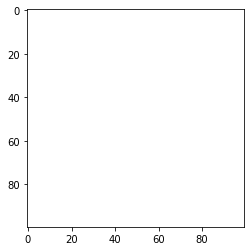

In [76]:
import matplotlib.pyplot as plt
plt.imshow(s2)

In [81]:
import pandas as pd
grouped_data = pd.read_csv('../Analytics/temp_data/grouped_data_untouched_6.csv')

In [82]:
V = skgstat.Variogram(grouped_data, data['sample'][1],maxlag=90, n_lags=25, model='gaussian', normalize=False)


,station,hour,latitude,longitude,temperature,closest_station_1_temp,closest_station_2_temp,closest_station_3_temp,closest_1_distance,closest_2_distance,closest_3_distance,day_of_year,adjusted_lst,valueImperviousfraction,valueTreefraction,valueBuildingheight,valueNearestDistWater,valueWaterfraction,valueBuildingfraction,beg_time
0,KWIFITCH21,0,42.997337,-89.439064,19.931034,19.862069,20.859937,19.931034,0.008206,0.010795,0.012080,166.0,0.658309,38.0,27.571429,0.0,803.621907,0.0,24.3175,2021-06-01
1,KWIFITCH21,1,42.997337,-89.439064,19.344828,19.275862,20.338973,19.379310,0.008206,0.010795,0.012080,166.0,0.902230,38.0,27.571429,0.0,803.621907,0.0,24.3175,2021-06-01
2,KWIFITCH21,2,42.997337,-89.439064,18.655172,18.620690,19.886975,18.689655,0.008206,0.010795,0.012080,166.0,1.146151,38.0,27.571429,0.0,803.621907,0.0,24.3175,2021-06-01
3,KWIFITCH21,3,42.997337,-89.439064,18.103448,18.206897,19.503942,18.241379,0.008206,0.010795,0.012080,166.0,1.159073,38.0,27.571429,0.0,803.621907,0.0,24.3175,2021-06-01
4,KWIFITCH21,4,42.997337,-89.439064,17.827586,18.000000,19.258841,17.965517,0.008206,0.010795,0.012080,166.0,1.171995,38.0,27.571429,0.0,803.621907,0.0,24.3175,2021-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,KWIWINDS10,19,43.206000,-89.348000,24.862069,24.792638,24.827586,24.655172,0.032850,0.051517,0.065299,166.0,-1.749784,31.0,10.400000,0.0,47.229699,0.0,14.9899,2021-06-01
2588,KWIWINDS10,20,43.206000,-89.348000,23.517241,23.564360,23.137931,23.068966,0.032850,0.051517,0.065299,166.0,-0.128572,31.0,10.400000,0.0,47.229699,0.0,14.9899,2021-06-01
2589,KWIWINDS10,21,43.206000,-89.348000,22.034483,22.439531,21.172414,22.034483,0.032850,0.051517,0.065299,166.0,1.211416,31.0,10.400000,0.0,47.229699,0.0,14.9899,2021-06-01
2590,KWIWINDS10,22,43.206000,-89.348000,21.068966,21.866427,20.103448,21.275862,0.032850,0.051517,0.065299,166.0,-1.510430,31.0,10.400000,0.0,47.229699,0.0,14.9899,2021-06-01


/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



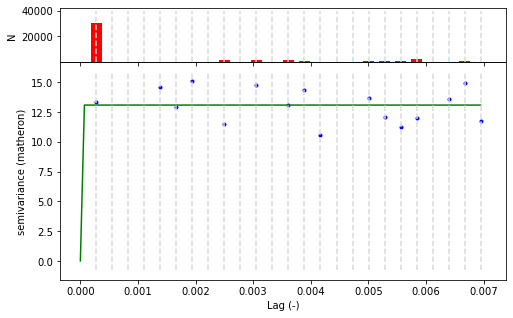

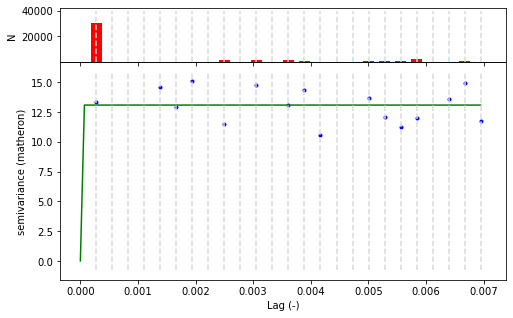

In [110]:
V = skgstat.Variogram(grouped_data[['latitude','longitude']], grouped_data.temperature,maxlag=0.02, n_lags=25, model='gaussian', normalize=False)
V.plot()

In [126]:
from lib import helper as help
data = grouped_data[['latitude','longitude','temperature']]
# data_new = help.convert_to_gpd(data,'epsg:4326',convert_to='epsg:7789')  
# data_new = data_new[['latitude','longitude','temperature']]
# data_new['latitude'] = 1000*data_new['latitude']/np.mean(data_new['latitude'])
# data_new['longitude'] = 1000*data_new['longitude']/np.mean(data_new['longitude'])
# data_new

# Latitude: 1 deg = 110.574 km
# Longitude: 1 deg = 111.320*cos(latitude) km
data['latitude'] = data['latitude']*110.574
data['longitude'] = np.cos(data['longitude'])*110.574
data

,latitude,longitude,temperature
0,4754.387541,10.634756,19.931034
1,4754.387541,10.634756,19.344828
2,4754.387541,10.634756,18.655172
3,4754.387541,10.634756,18.103448
4,4754.387541,10.634756,17.827586
...,...,...,...
2587,4777.460244,20.599476,24.862069
2588,4777.460244,20.599476,23.517241
2589,4777.460244,20.599476,22.034483
2590,4777.460244,20.599476,21.068966


/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



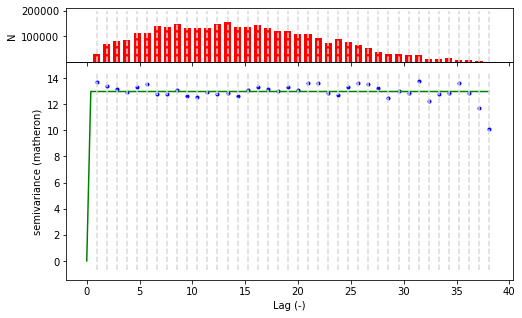

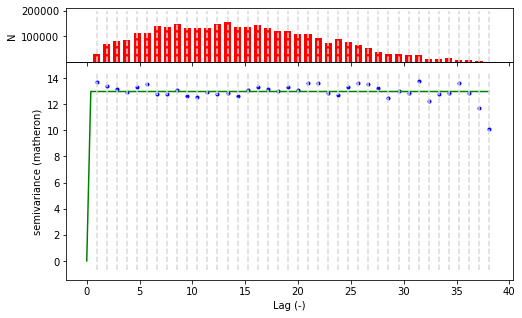

In [139]:
V = skgstat.Variogram(data[['latitude','longitude']], data.temperature,maxlag=100, n_lags=40, model='gaussian', normalize=False)
V.plot()

In [ ]:
#epsg of plane coordinates
